In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### Augmentation

In [ ]:
def flip_image(image): return tf.image.flip_left_right(image)
def rotate_image(image): return tf.image.rot90(image, k=1)
def brightness_image(image): return tf.image.adjust_brightness(image, 0.2)

In [ ]:
def augment_multiple_versions(x, y):
    augmented_images = []
    augmented_labels = []

    for img, label in zip(x, y):
        augmented_images.append(img)  # Original
        augmented_labels.append(label)

        augmented_images.append(flip_image(img))
        augmented_labels.append(label)

        augmented_images.append(rotate_image(img))
        augmented_labels.append(label)

        augmented_images.append(brightness_image(img))
        augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

In [ ]:
x_train_aug, y_train_aug = augment_multiple_versions(x_train, y_train)

In [ ]:
print("Original training samples:", len(x_train))
print("After augmentation:", len(x_train_aug))

Original training samples: 50000
After augmentation: 200000


In [ ]:
IMG_SIZE = 32
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Preprocessing function (resize + normalize)
def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train_aug, y_train_aug))
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(10000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

/tmp/ipython-input-10-725063702.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 103s 7ms/step - accuracy: 0.4308 - loss: 1.6302 - val_accuracy: 0.5254 - val_loss: 1.4149
Epoch 2/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 91s 7ms/step - accuracy: 0.5113 - loss: 1.3984 - val_accuracy: 0.5583 - val_loss: 1.2866
Epoch 3/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 88s 7ms/step - accuracy: 0.5377 - loss: 1.3229 - val_accuracy: 0.5703 - val_loss: 1.2572
Epoch 4/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - accuracy: 0.5544 - loss: 1.2766 - val_accuracy: 0.5859 - val_loss: 1.2101
Epoch 5/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - accuracy: 0.5691 - loss: 1.2371 - val_accuracy: 0.5998 - val_loss: 1.1790
Epoch 6/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/step - accuracy: 0.5801 - loss: 1.2090 - val_accuracy: 0.6057 - val_loss: 1.1853
Epoch 7/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 140s 7ms/step - accuracy: 0.5868 - loss: 1.1837 - val_accuracy: 0.6006 - val_loss: 1.1988
Epoch 8/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - accur

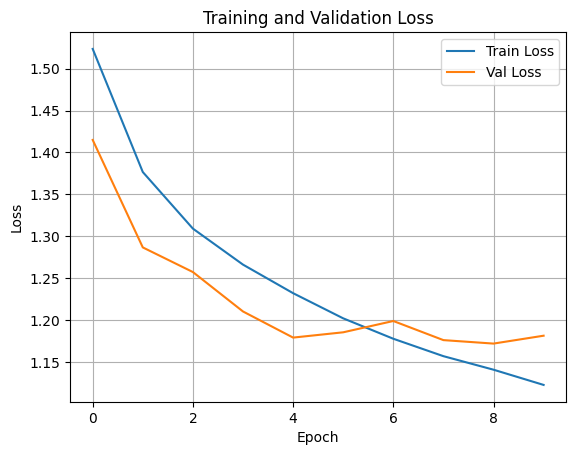

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


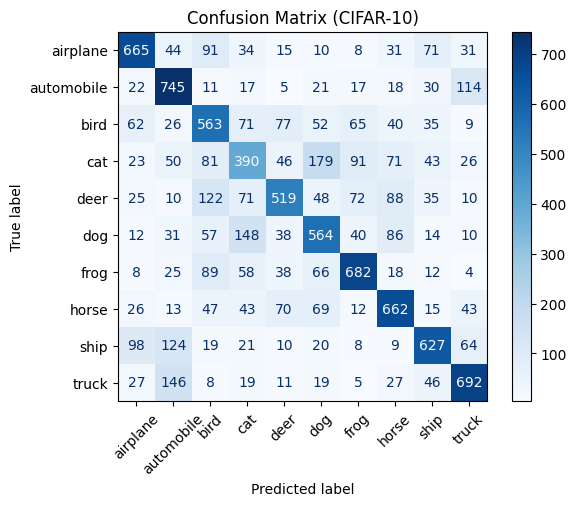

In [ ]:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (CIFAR-10)")
plt.grid(False)
plt.show()